<a href="https://colab.research.google.com/github/magicmercedes/ainanda-text-sentiment-analysis/blob/main/ainanda_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AINANDA: 
AI BASED TEXT CLASSIFIER

'`The Goddess of Happiness is gonna evaluate your text for you.`'

This notebook shows how to preprocess the data and train sentiment model on twitter dataset in Google Colab.

    Colab Runtime type: Python3, GPU enabled.

(To enable GPU in your notebook, select the following from task bar: options −> Runtime ⇨ Change runtime type:  None ⇨ GPU


---



## Install the required Packages
Import libraries


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
from gensim.models import Word2Vec

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

nltk.download('stopwords')

import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Downloading Kaggle dataset "[Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)" via Kaggle API

In [ ]:
#Setting up Kaggle API in jupyter 
!pip install kaggle 

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
#Download  Twitter dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140
#unzip
!unzip sentiment140.zip

 93% 75.0M/80.9M [00:00<00:00, 61.2MB/s]
100% 80.9M/80.9M [00:01<00:00, 79.6MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


### Read the Dataset
loading the data

In [ ]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
df.columns = ["target", "ids", "date", "flag", "user", "text"]

In [ ]:
print(df.shape)

(1599999, 6)


Reduce amount of Data for (optional)

In [ ]:
data_pos = df[df['target'] == 4]
data_neg = df[df['target'] == 0]
print(data_pos.shape)
print(data_neg.shape)

(800000, 6)
(799999, 6)


In [ ]:
#Reducing amound of Data we take  200K twitter data
data_pos = data_pos.iloc[:int(100000)] # 100K positive labeled data
data_neg = data_neg.iloc[:int(100000)] # 100K negative labeled data

#Combining positive and negative tweets
df = pd.concat([data_pos, data_neg])

In [ ]:
#decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
#def decode_sentiment(label):
#    return decode_map[int(label)]

#df.target = df.target.apply(lambda x: decode_sentiment(x))

In [ ]:
df.head() #five top records of data

,target,ids,date,flag,user,text
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


## Data pre-processing

“stop words” usually refers to the most common words in a language and they are the words in any language which does not add much meaning to a sentence.

In [ ]:
stop_words = stopwords.words("english")
#apply stemming on the dataset
stemmer = SnowballStemmer("english")
# stop words can change the meaning of our text. So we will remove 'not'and 'but' in the stopword list.
stop_words.remove('not')
stop_words.remove('but')

", ".join(stop_words)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, need

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters (numbers, punctuation..etc) as well as convert the text in lower case
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x)) # applying the preprocess function thorough all text data.

In [ ]:
#Split your data into training and validating (90/10 is indeed a good starting point when we have +1M data)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1439999
TEST size: 160000


### Word2vec embeddings
Word2vec “vectorizes” about words, and by doing so it makes natural language computer-readable. 
- We will be training our own word2vec on a custom corpus. For training the model we will be using gensim

In [ ]:
documents = [_text.split() for _text in df_train.text] 

In [ ]:
# train word2vec on the twitter dataset
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [ ]:
#Build vocabulary from a sequence of documents 
w2v_model.build_vocab(documents)

In [ ]:
#Find number of words in vocabulary (~30k words).
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30300


In [ ]:
#train word2vec model using Gensim library with our own dataset
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(266142885, 301524352)

In [ ]:
#Finding the top words that are similar to a target word.
w2v_model.most_similar("happy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('celebrated', 0.42875319719314575),
 ('celebrating', 0.4062950611114502),
 ('happiest', 0.39618024230003357),
 ('happier', 0.3877427875995636),
 ('proud', 0.3863334059715271),
 ('celebrations', 0.3789922595024109),
 ('blessed', 0.3780200779438019),
 ('happpy', 0.37563860416412354),
 ('wonderful', 0.37307682633399963),
 ('hapy', 0.36275720596313477)]

In [ ]:
w2v_model.most_similar("sad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('upset', 0.6068512201309204),
 ('depressed', 0.5406486988067627),
 ('bummed', 0.5367264747619629),
 ('sadder', 0.45172005891799927),
 ('depressing', 0.43433141708374023),
 ('sadd', 0.4338465631008148),
 ('cry', 0.4290161430835724),
 ('dissapointed', 0.4252946376800537),
 ('heartbroken', 0.4194280207157135),
 ('disappointed', 0.418348491191864)]

### Tokenize Text

In [ ]:
#method for vectorizing texts, or/and turning texts into sequences.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290444


In [ ]:
# texts_to_sequences => Transforms each text in texts to a sequence of integers
# pad_sequences => transforms a list of lists of integers into a matrix of shape

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300) 
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [ ]:
#test
NEUTRAL = 'NEUTRAL'
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

[4, 0, 'NEUTRAL']

### Label encoding

Label Encoding refers to converting the data into numeric form so as to convert it into the machine-readable form

In [ ]:
# creating instance of labelencoder 
encoder = LabelEncoder()
#
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1279999, 1)
y_test (320000, 1)


### Embedding layer
Embedding layer enables us to convert each word into a fixed length vector of defined size
- This layer can only be used as the first layer in a model.

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

NameError: ignored

In [ ]:
#creating the embedding
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

# Build a Model

In [ ]:
model = Sequential()
model.add(embedding_layer) #Embeddings provide the presentation of words and their relative meanings
model.add(Dropout(0.5)) #Dropout layer: drop some neurons from previous layers to avoid the overfitting problem
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #LSTM is a sequance predictor of next coming words. 
model.add(Dense(1, activation='sigmoid')) #activation function is sigmoid for only one output.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87133200  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,293,701
Trainable params: 160,501
Non-trainable params: 87,133,200
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
#This builds the model
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
1125/1125 [==============================] - 1175s 1s/step - loss: 0.5171 - accuracy: 0.7399 - val_loss: 0.4483 - val_accuracy: 0.7881
Epoch 2/10
1125/1125 [==============================] - 1163s 1s/step - loss: 0.4680 - accuracy: 0.7749 - val_loss: 0.4417 - val_accuracy: 0.7930
Epoch 3/10
1125/1125 [==============================] - 1148s 1s/step - loss: 0.4564 - accuracy: 0.7820 - val_loss: 0.4368 - val_accuracy: 0.7960
Epoch 4/10
1125/1125 [==============================] - 1148s 1s/step - loss: 0.4522 - accuracy: 0.7844 - val_loss: 0.4356 - val_accuracy: 0.7974
Epoch 5/10
1125/1125 [==============================] - 1141s 1s/step - loss: 0.4493 - accuracy: 0.7858 - val_loss: 0.4312 - val_accuracy: 0.7991
Epoch 6/10
1125/1125 [==============================] - 1137s 1s/step - loss: 0.4469 - accuracy: 0.7875 - val_loss: 0.4299 - val_accuracy: 0.8000
Epoch 7/10
1125/1125 [==============================] - 1154s 1s/step - loss: 0.4467 - accuracy: 0.7878 - val_loss: 0.4291 -

##Evaluate the results

Accuracy is the number of correctly classify tweets from all the tweets 

In [ ]:
#Testing the Trained model on test data
y_pred = model.predict(x_test) 


score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 52s 167ms/step - loss: 0.4266 - accuracy: 0.8019

ACCURACY: 0.8018593788146973
LOSS: 0.4265756905078888


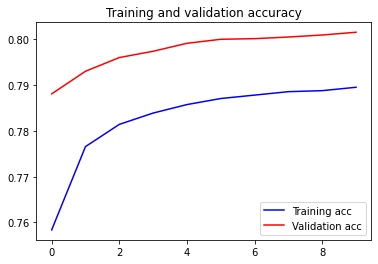

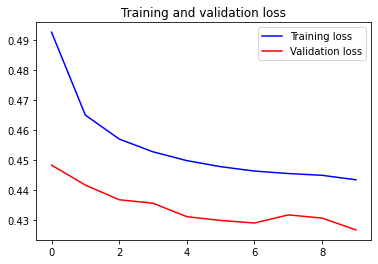

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

#Save model

In [ ]:
model.save("ainanda_model_v1.h5")
w2v_model.save('ainanda_model_v1.w2v')
pickle.dump(tokenizer, open('tokenizer.pkl', "wb"), protocol=0)
pickle.dump(encoder, open('encoder.pkl', "wb"), protocol=0)

**Inspecting the Model**

-  "ainanda_inference.ipynb" to visualize the results through colab Notebook. 


---



